In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Number Classification with TensorFlow

Copyright 2019 The TensorFlow Authors.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/quickstart/beginner"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This short introduction uses [Keras](https://www.tensorflow.org/guide/keras/overview) to:

1. Load a prebuilt dataset.
1. Build a neural network machine learning model that classifies images.
2. Train this neural network.
3. Evaluate the accuracy of the model.

This tutorial is a [Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb) notebook. Python programs are run directly in the browser—a great way to learn and use TensorFlow. To follow this tutorial, run the notebook in Google Colab by clicking the button at the top of this page.

1. In Colab, connect to a Python runtime: At the top-right of the menu bar, select *CONNECT*.
2. To run all the code in the notebook, select **Runtime** > **Run all**. To run the code cells one at a time, hover over each cell and select the **Run cell** icon.

## Set up TensorFlow

Import TensorFlow into your program to get started:

In [2]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.0


If you are following along in your own development environment, rather than [Colab](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb), see the [install guide](https://www.tensorflow.org/install) for setting up TensorFlow for development.

Note: Make sure you have upgraded to the latest `pip` to install the TensorFlow 2 package if you are using your own development environment. See the [install guide](https://www.tensorflow.org/install) for details.

## Load a dataset

Load and prepare the MNIST dataset. The pixel values of the images range from 0 through 255. Scale these values to a range of 0 to 1 by dividing the values by `255.0`. This also converts the sample data from integers to floating-point numbers:

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

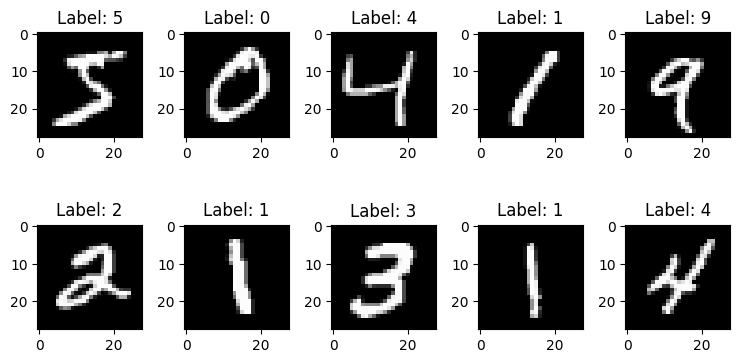

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

num_row = 2
num_col = 5
num = num_row * num_col
images = x_train[:num]
labels = y_train[:num]

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
for i in range(num):
    ax = axes[i // num_col, i % num_col]
    ax.imshow(images[i], cmap="gray")
    ax.set_title("Label: {}".format(labels[i]))
plt.tight_layout()
plt.show()

## Build a machine learning model

Build a `tf.keras.Sequential` model:

In [5]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10),
    ]
)

/Users/ariefrahmansyah/Library/Caches/pypoetry/virtualenvs/applied-python-training-MLD32oJZ-py3.12/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[`Sequential`](https://www.tensorflow.org/guide/keras/sequential_model) is useful for stacking layers where each layer has one input [tensor](https://www.tensorflow.org/guide/tensor) and one output tensor. Layers are functions with a known mathematical structure that can be reused and have trainable variables. Most TensorFlow models are composed of layers. This model uses the [`Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten), [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), and [`Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers.

For each example, the model returns a vector of [logits](https://developers.google.com/machine-learning/glossary#logits) or [log-odds](https://developers.google.com/machine-learning/glossary#log-odds) scores, one for each class.

In [6]:
predictions = model(x_train[:1]).numpy()
predictions

array([[-0.3805407 ,  0.80421233, -0.31978986, -0.670506  ,  0.06069487,
        -0.679445  ,  0.40332592,  0.47335294, -0.30201632,  0.285113  ]],
      dtype=float32)

The `tf.nn.softmax` function converts these logits to *probabilities* for each class: 

In [7]:
tf.nn.softmax(predictions).numpy()

array([[0.06272263, 0.20509543, 0.06665121, 0.04693469, 0.09751029,
        0.04651701, 0.13735777, 0.1473213 , 0.06784642, 0.12204331]],
      dtype=float32)

Note: It is possible to bake the `tf.nn.softmax` function into the activation function for the last layer of the network. While this can make the model output more directly interpretable, this approach is discouraged as it's impossible to provide an exact and numerically stable loss calculation for all models when using a softmax output. 

Define a loss function for training using `losses.SparseCategoricalCrossentropy`:

In [8]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

The loss function takes a vector of ground truth values and a vector of logits and returns a scalar loss for each example. This loss is equal to the negative log probability of the true class: The loss is zero if the model is sure of the correct class.

This untrained model gives probabilities close to random (1/10 for each class), so the initial loss should be close to `-tf.math.log(1/10) ~= 2.3`.

In [9]:
loss_fn(y_train[:1], predictions).numpy()

3.0679374

Before you start training, configure and compile the model using Keras `Model.compile`. Set the [`optimizer`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) class to `adam`, set the `loss` to the `loss_fn` function you defined earlier, and specify a metric to be evaluated for the model by setting the `metrics` parameter to `accuracy`.

In [10]:
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])

## Train and evaluate your model

Use the `Model.fit` method to adjust your model parameters and minimize the loss: 

In [11]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 995us/step - accuracy: 0.8607 - loss: 0.4769
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9549 - loss: 0.1528
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 991us/step - accuracy: 0.9666 - loss: 0.1097
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 985us/step - accuracy: 0.9727 - loss: 0.0898
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9771 - loss: 0.0764


 314/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7341 - loss: 0.9244

 356/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7463 - loss: 0.8834

 398/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7564 - loss: 0.8490

 438/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7648 - loss: 0.8204

 480/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7727 - loss: 0.7937

 523/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7797 - loss: 0.7697

 564/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7857 - loss: 0.7490

 604/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7911 - loss: 0.7305

 646/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7962 - loss: 0.7128

 689/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8009 - loss: 0.6964

 730/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8050 - loss: 0.6820

 772/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8089 - loss: 0.6682

 813/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8125 - loss: 0.6557

 855/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8159 - loss: 0.6437

 897/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8191 - loss: 0.6325

 938/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8221 - loss: 0.6222

 978/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8248 - loss: 0.6127

1019/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8274 - loss: 0.6035

1059/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8298 - loss: 0.5950

1100/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8321 - loss: 0.5868

1141/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8344 - loss: 0.5789

1181/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8364 - loss: 0.5716

1221/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8384 - loss: 0.5647

1259/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8402 - loss: 0.5583

1298/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8420 - loss: 0.5521

1336/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8437 - loss: 0.5462

1375/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8453 - loss: 0.5404

1414/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8469 - loss: 0.5348

1453/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8484 - loss: 0.5294

1491/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8499 - loss: 0.5243

1532/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8514 - loss: 0.5190

1573/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8528 - loss: 0.5139

1615/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8543 - loss: 0.5089

1655/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8556 - loss: 0.5042

1695/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8569 - loss: 0.4997

1736/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8581 - loss: 0.4953

1777/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8594 - loss: 0.4910

1816/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8605 - loss: 0.4870

1857/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8616 - loss: 0.4829

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8622 - loss: 0.4811


Epoch 2/5


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:30 48ms/step - accuracy: 0.9375 - loss: 0.3879

  42/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9523 - loss: 0.1747   

  82/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9543 - loss: 0.1602

 122/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9551 - loss: 0.1561

 165/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9552 - loss: 0.1541

 207/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9549 - loss: 0.1536

 249/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9544 - loss: 0.1538

 292/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9539 - loss: 0.1547

 334/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9536 - loss: 0.1552

 376/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9534 - loss: 0.1557

 417/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9532 - loss: 0.1562

 458/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9531 - loss: 0.1567

 500/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9530 - loss: 0.1570

 542/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9530 - loss: 0.1572

 584/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9530 - loss: 0.1573

 627/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9531 - loss: 0.1573

 669/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9531 - loss: 0.1573

 711/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9531 - loss: 0.1575

 753/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9531 - loss: 0.1576

 796/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9531 - loss: 0.1576

 838/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9532 - loss: 0.1576

 881/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9532 - loss: 0.1576

 924/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9533 - loss: 0.1576

 967/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9534 - loss: 0.1576

1010/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9534 - loss: 0.1575

1052/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9535 - loss: 0.1574

1095/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9535 - loss: 0.1573

1137/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9536 - loss: 0.1572

1178/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9537 - loss: 0.1570

1220/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9537 - loss: 0.1568

1261/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9538 - loss: 0.1566

1304/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9539 - loss: 0.1564

1347/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9540 - loss: 0.1562

1389/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9540 - loss: 0.1561

1431/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9541 - loss: 0.1559

1473/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9542 - loss: 0.1557

1514/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9542 - loss: 0.1555

1556/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9543 - loss: 0.1553

1597/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9544 - loss: 0.1551

1638/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9544 - loss: 0.1550

1680/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9545 - loss: 0.1548

1723/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9545 - loss: 0.1546

1764/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9546 - loss: 0.1544

1806/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9546 - loss: 0.1542

1847/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9547 - loss: 0.1541

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9547 - loss: 0.1539


Epoch 3/5


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:26 46ms/step - accuracy: 0.9688 - loss: 0.2087

  41/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9718 - loss: 0.1163   

  80/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9684 - loss: 0.1186

 122/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9669 - loss: 0.1197

 166/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9667 - loss: 0.1187

 210/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9669 - loss: 0.1177

 254/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9671 - loss: 0.1166

 299/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9674 - loss: 0.1157

 344/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9675 - loss: 0.1152

 388/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9676 - loss: 0.1145

 431/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9676 - loss: 0.1141

 471/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9677 - loss: 0.1138

 514/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9678 - loss: 0.1135

 558/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9678 - loss: 0.1131

 601/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9678 - loss: 0.1129

 644/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9678 - loss: 0.1127

 686/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9678 - loss: 0.1126

 727/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9677 - loss: 0.1125

 768/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9677 - loss: 0.1125

 811/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9677 - loss: 0.1125

 853/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9677 - loss: 0.1124

 896/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9677 - loss: 0.1122

 938/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9677 - loss: 0.1121

 980/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9677 - loss: 0.1120

1023/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9677 - loss: 0.1119

1066/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9677 - loss: 0.1117

1110/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9677 - loss: 0.1116

1154/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9677 - loss: 0.1115

1198/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9677 - loss: 0.1115

1241/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9677 - loss: 0.1114

1285/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9677 - loss: 0.1113

1327/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9677 - loss: 0.1112

1370/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9677 - loss: 0.1112

1414/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9677 - loss: 0.1111

1458/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9676 - loss: 0.1111

1501/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9676 - loss: 0.1110

1543/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9676 - loss: 0.1110

1585/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9676 - loss: 0.1109

1628/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9676 - loss: 0.1109

1670/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9676 - loss: 0.1109

1713/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9676 - loss: 0.1108

1756/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9676 - loss: 0.1108

1799/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9676 - loss: 0.1107

1843/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9676 - loss: 0.1107

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9676 - loss: 0.1107


Epoch 4/5


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:26 46ms/step - accuracy: 0.9375 - loss: 0.1125

  42/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9758 - loss: 0.0701   

  85/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9752 - loss: 0.0739

 128/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9754 - loss: 0.0742

 173/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9758 - loss: 0.0745

 217/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9758 - loss: 0.0755

 261/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9756 - loss: 0.0766

 305/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9755 - loss: 0.0774

 349/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9753 - loss: 0.0781

 393/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9751 - loss: 0.0789

 438/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9749 - loss: 0.0794

 483/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9749 - loss: 0.0798

 528/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9748 - loss: 0.0802

 572/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9747 - loss: 0.0806

 616/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9746 - loss: 0.0810

 660/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9746 - loss: 0.0813

 705/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9745 - loss: 0.0815

 749/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9745 - loss: 0.0816

 792/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9745 - loss: 0.0818

 836/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9744 - loss: 0.0820

 880/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9744 - loss: 0.0821

 924/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9744 - loss: 0.0822

 967/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9744 - loss: 0.0823

1011/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9743 - loss: 0.0824

1055/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9743 - loss: 0.0826

1097/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9742 - loss: 0.0827

1140/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9742 - loss: 0.0828

1184/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9742 - loss: 0.0830

1228/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9741 - loss: 0.0831

1272/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9741 - loss: 0.0832

1316/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9741 - loss: 0.0832

1360/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9741 - loss: 0.0833

1403/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9740 - loss: 0.0834

1447/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9740 - loss: 0.0835

1491/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9740 - loss: 0.0836

1535/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9739 - loss: 0.0837

1578/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9739 - loss: 0.0838

1621/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9739 - loss: 0.0839

1664/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9739 - loss: 0.0840

1708/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9739 - loss: 0.0840

1752/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9738 - loss: 0.0841

1796/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9738 - loss: 0.0842

1839/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9738 - loss: 0.0843

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9738 - loss: 0.0843


Epoch 5/5


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:25 46ms/step - accuracy: 1.0000 - loss: 0.0105

  42/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9725 - loss: 0.0800   

  84/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9727 - loss: 0.0810

 128/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9725 - loss: 0.0817

 172/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9731 - loss: 0.0814

 216/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9738 - loss: 0.0805

 260/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9745 - loss: 0.0792

 304/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9749 - loss: 0.0784

 349/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9751 - loss: 0.0778

 392/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9754 - loss: 0.0775

 435/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9755 - loss: 0.0773

 479/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9756 - loss: 0.0773

 522/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9758 - loss: 0.0772

 565/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9759 - loss: 0.0772

 609/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9760 - loss: 0.0772

 651/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9760 - loss: 0.0772

 693/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9761 - loss: 0.0772

 736/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9762 - loss: 0.0772

 778/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9762 - loss: 0.0771

 821/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9762 - loss: 0.0771

 864/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9763 - loss: 0.0771

 906/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9763 - loss: 0.0771

 950/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9763 - loss: 0.0771

 994/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9764 - loss: 0.0770

1037/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9764 - loss: 0.0770

1081/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9764 - loss: 0.0769

1125/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9764 - loss: 0.0769

1169/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9764 - loss: 0.0769

1214/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9764 - loss: 0.0769

1258/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9764 - loss: 0.0769

1302/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9764 - loss: 0.0769

1346/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9764 - loss: 0.0769

1389/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9764 - loss: 0.0769

1432/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9764 - loss: 0.0769

1476/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9764 - loss: 0.0769

1518/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9764 - loss: 0.0769

1558/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9764 - loss: 0.0769

1600/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9764 - loss: 0.0769

1642/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9764 - loss: 0.0769

1684/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9764 - loss: 0.0769

1727/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9764 - loss: 0.0769

1770/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9764 - loss: 0.0769

1814/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9764 - loss: 0.0769

1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9764 - loss: 0.0769

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9764 - loss: 0.0769


The `Model.evaluate` method checks the model's performance, usually on a [validation set](https://developers.google.com/machine-learning/glossary#validation-set) or [test set](https://developers.google.com/machine-learning/glossary#test-set).

In [12]:
model.evaluate(x_test, y_test, verbose=2)

313/313 - 0s - 468us/step - accuracy: 0.9753 - loss: 0.0798


[0.07982742041349411, 0.9753000140190125]

The image classifier is now trained to ~98% accuracy on this dataset. To learn more, read the [TensorFlow tutorials](https://www.tensorflow.org/tutorials/).

If you want your model to return a probability, you can wrap the trained model, and attach the softmax to it:

In [13]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [14]:
probability_model(x_test[:5])

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[1.09569520e-07, 2.81650453e-10, 2.76106198e-06, 1.09500957e-04,
        5.27111133e-11, 2.14683382e-06, 2.39292028e-12, 9.99881864e-01,
        4.06290326e-07, 3.12417910e-06],
       [9.36238642e-10, 9.94658796e-04, 9.99004304e-01, 9.69198368e-07,
        1.19458539e-14, 1.32637403e-08, 3.25292042e-08, 3.50566516e-12,
        6.19934113e-08, 1.05918810e-14],
       [2.11339966e-06, 9.99089956e-01, 2.31639220e-04, 9.04002718e-06,
        1.27908625e-05, 6.04543357e-06, 1.57848790e-05, 5.41534158e-04,
        8.97237696e-05, 1.44716455e-06],
       [9.99949574e-01, 6.36652331e-09, 2.91350098e-05, 6.50657412e-08,
        3.27179244e-08, 2.34230447e-06, 7.51126618e-06, 9.89659202e-06,
        7.71864705e-08, 1.30633589e-06],
       [4.48162268e-07, 7.70599016e-08, 1.51247777e-05, 3.49523965e-08,
        9.97868180e-01, 1.17272137e-07, 2.39243946e-06, 6.84397091e-05,
        7.22275331e-07, 2.04430916e-03]], dtype=float32)>

## Conclusion

Congratulations! You have trained a machine learning model using a prebuilt dataset using the [Keras](https://www.tensorflow.org/guide/keras/overview) API.

For more examples of using Keras, check out the [tutorials](https://www.tensorflow.org/tutorials/keras/). To learn more about building models with Keras, read the [guides](https://www.tensorflow.org/guide/keras). If you want learn more about loading and preparing data, see the tutorials on [image data loading](https://www.tensorflow.org/tutorials/load_data/images) or [CSV data loading](https://www.tensorflow.org/tutorials/load_data/csv).
